In [72]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/ayyappa1993/avai-assignment/blob/main/task1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    """

    !{sys.executable} -m pip install pillow

    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/ayyappa1993/avai-assignment/main/images/chair.jpg

    !pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate
    !pip install "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
    """

PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

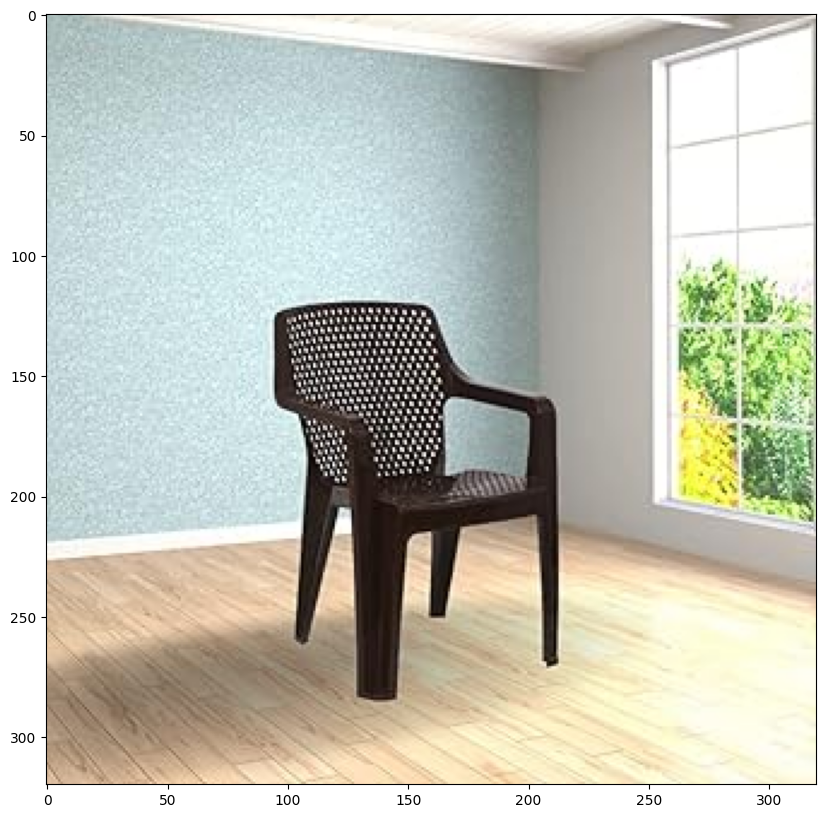

In [5]:
image = cv2.imread('images/chair.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [6]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [7]:
predictor.set_image(image)

In [8]:
input_point = np.array([[150, 200]])
input_label = np.array([1])

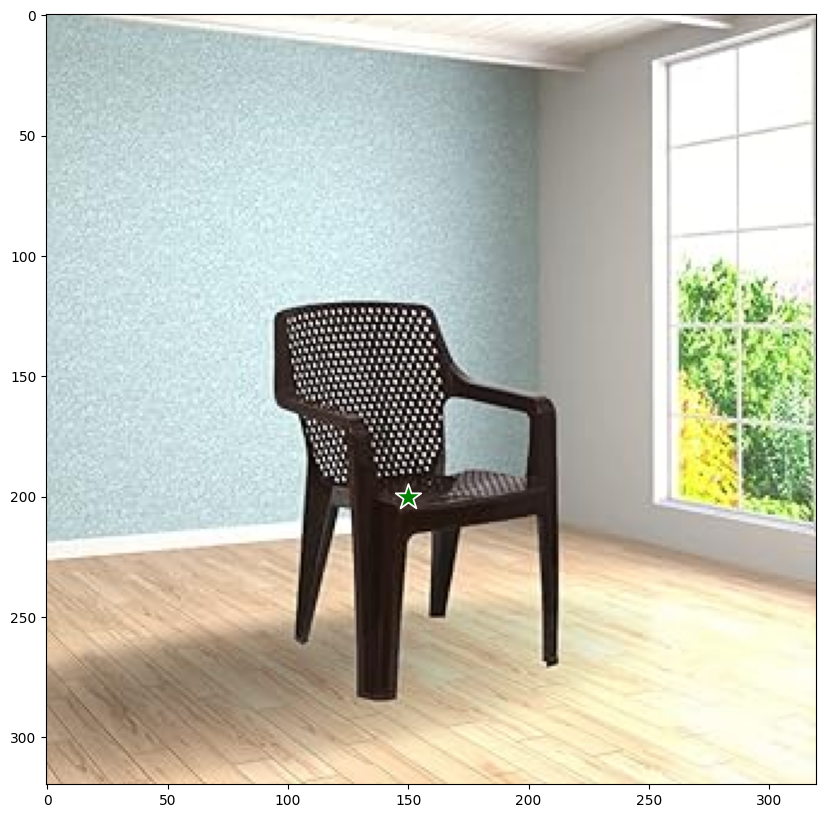

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [11]:
masks.shape  # (number_of_masks) x H x W


(3, 320, 320)

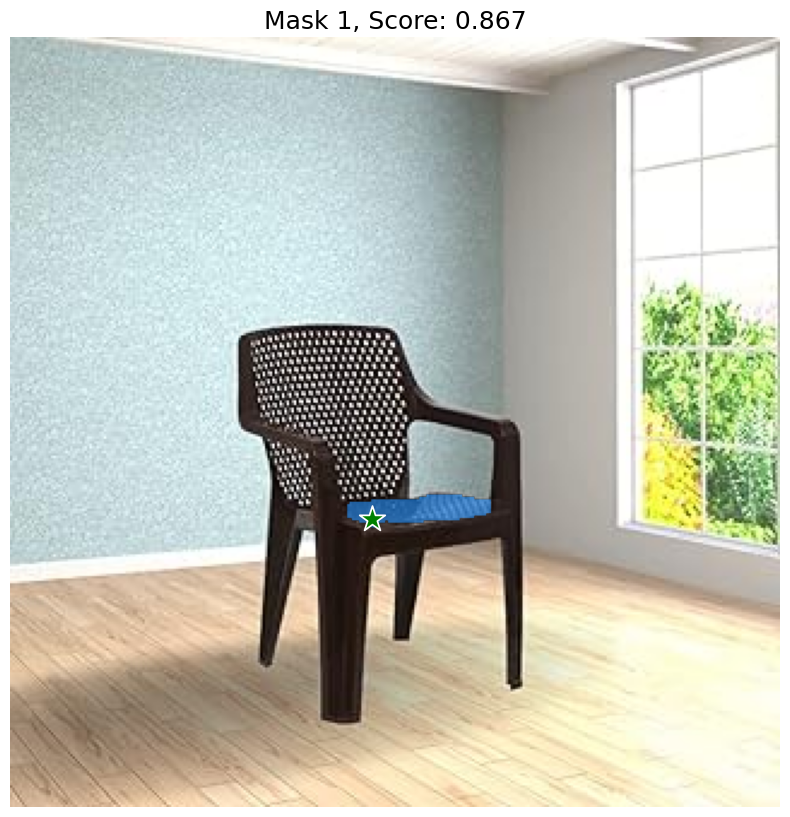

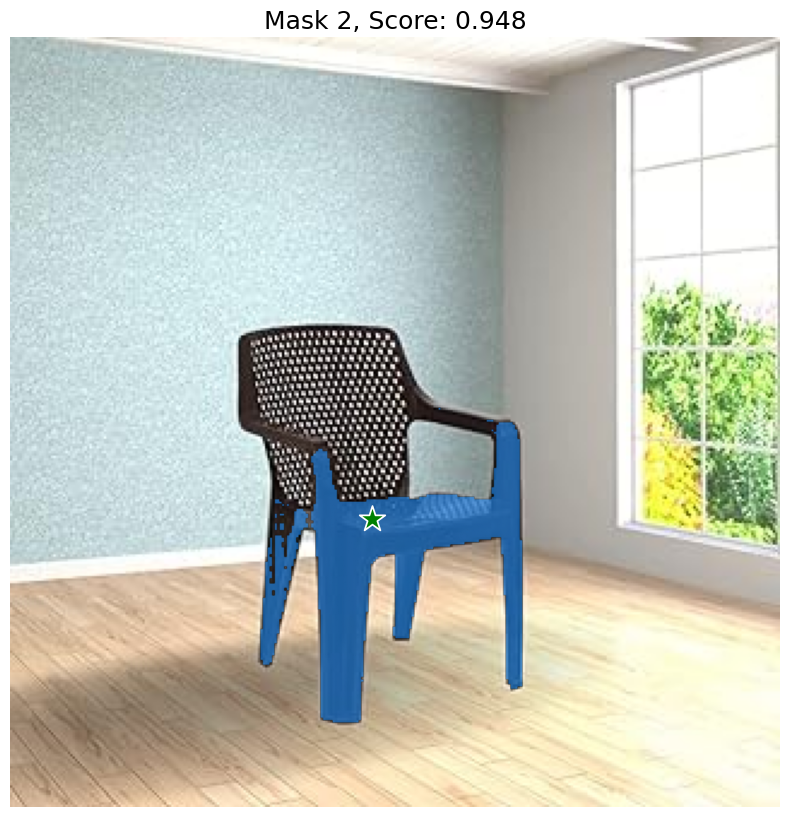

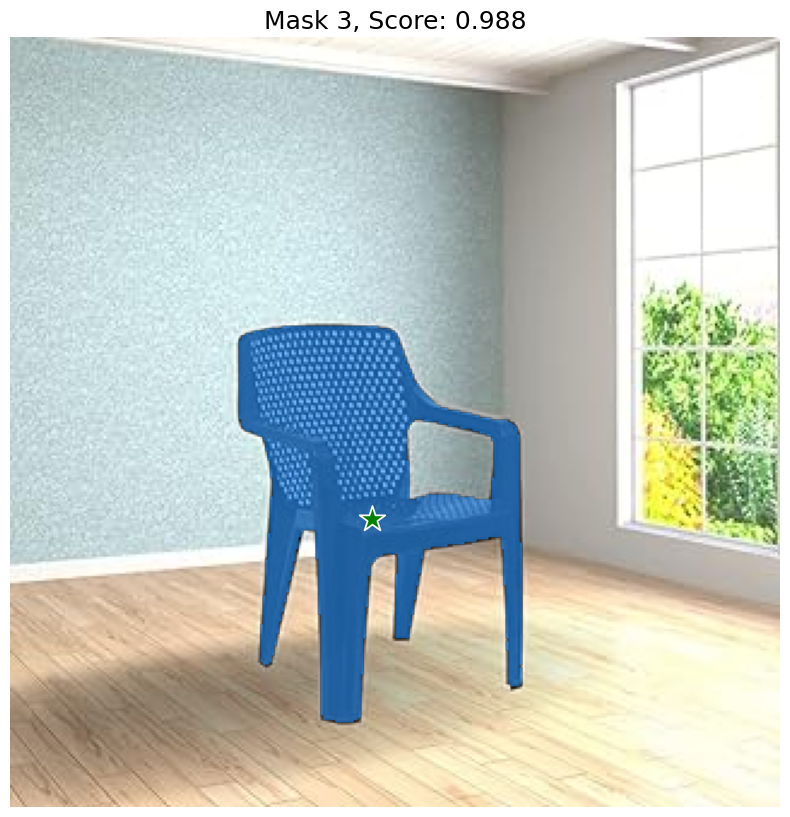

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


In [68]:
final_mask = (masks[2, :, :].astype(int)*255).astype('uint8')

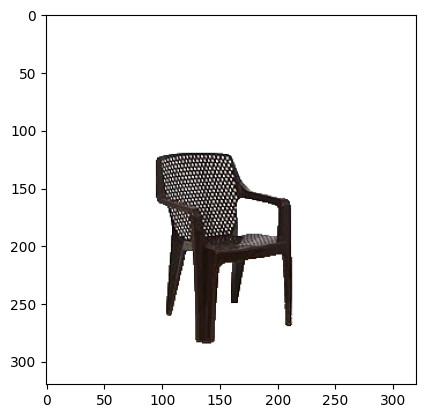

True

In [73]:
_, mask = cv2.threshold(final_mask, 128, 255, cv2.THRESH_BINARY)

# Apply the mask to the image
masked_img = cv2.bitwise_and(image, image, mask=final_mask)

# Create a white image of the same size
white_img = np.ones_like(image, dtype=np.uint8) * 255

# Copy the masked image onto the white background only where the mask is set
result = np.where(mask[..., None] == 255, masked_img, white_img)

plt.imshow(result)
plt.show()
cv2.imwrite("/content/drive/MyDrive/fg_chair.jpg", result)